In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%matplotlib inline

from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.ndimage import distance_transform_edt
import skimage as sk

import emc2d

np.random.seed(2020)

## SImulated data

In [3]:
intensity = np.load("./data/4BED_t40_d5000.npy")

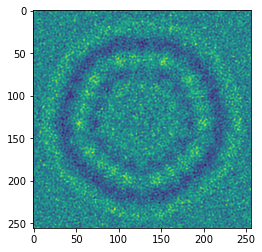

In [4]:
plt.imshow(intensity)

In [5]:
drift_radius = (15, 15)
mean_count= 0.05
motion_sigma = 1.
num_frames = 500
frame_size = (128, 128)
model_size = (frame_size[0] + 2*drift_radius[0], frame_size[1] + 2*drift_radius[1])
model = emc2d.sim.build_model(intensity, model_size=model_size, mean_count=mean_count)
n_drifts = (2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)

frames, traj = emc2d.sim.generate_frames(
    intensity, 
    frame_size, 
    drift_radius=drift_radius, 
    num_frames=num_frames, 
    mean_count=mean_count, 
    motion_sigma=motion_sigma)

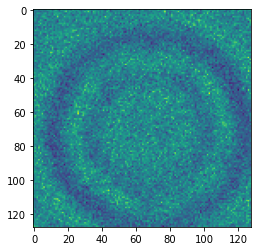

In [6]:
plt.imshow(frames[:].sum(0))

## Initialize EMC

In [7]:
emc = emc2d.core.EMC(
    frames=frames, 
    frame_size=(128, 128), 
    drift_radius=drift_radius, 
    init_model='random')

nnz / data_size = 4.77%, using dense data format


Text(0.5, 1.0, 'initial model')

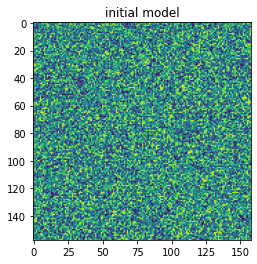

In [8]:
plt.imshow(emc.curr_model)
plt.title("initial model")

## Coarse graining the drift space

In [9]:
drift_in_use2 = emc2d.utils.drift_space_coarse_grain(drift_radius=drift_radius, multiple=(2, 2))
print(f"drifts {(2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)} reduced to  {len(drift_in_use2)}")

drifts 961 reduced to  225


In [10]:
emc.run(iterations=10, drifts_in_use=drift_in_use2, lpfs=2.0)

100%|██████████| 10/10 [00:01<00:00,  7.14it/s]                                                                        


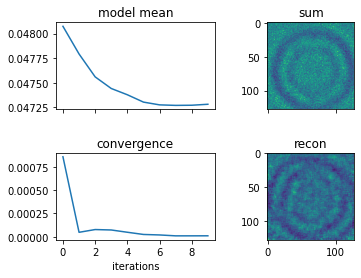

In [11]:
fig = emc2d.viz.show_emc_state(emc)

mse = 202.668


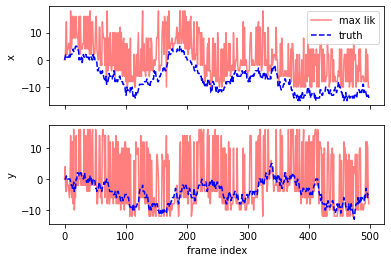

In [12]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [13]:
pmat0 = emc.folded_membership_probability
bmap0 = emc.binary_location_map(threshold=1e-3)

## Select subregions for each frame

In [15]:
bmap1 = emc2d.utils.broaden_searching_regions(bmap0, r=3)
bmap2 = emc2d.utils.impose_continuity(bmap1, broaden_r=3)

frame_drifts_in_use = emc2d.utils.bmap_to_frame_drift_indices(bmap2)

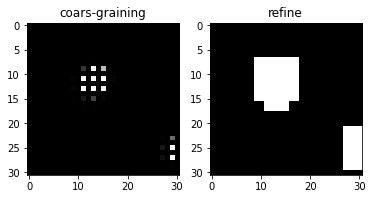

In [16]:
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(pmat0[0], vmin=0, vmax=0.005, cmap='gray')
ax2.imshow(bmap1[0], cmap='gray')
ax1.set_title("coars-graining")
ax2.set_title("refine");

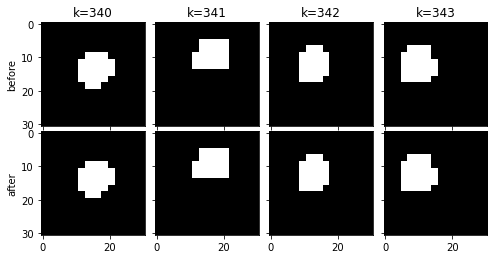

In [17]:
k0 = 340
_, axes = plt.subplots(nrows=2, ncols=4, sharex='all', sharey='all', figsize=(8, 4))

for i, ax in enumerate(axes[0]):
    ax.imshow(bmap1[k0 + i], cmap='gray')
    ax.set_title(f"k={k0+i}")
    
for i, ax in enumerate(axes[1]):
    ax.imshow(bmap2[k0 + i], cmap='gray')
    
axes[0][0].set_ylabel('before')
axes[1][0].set_ylabel('after')
    
plt.subplots_adjust(hspace=0, wspace=0.1)

In [18]:
emc.run_frame_sparse(iterations=10, frame_drifts_in_use=frame_drifts_in_use, lpfs=1.5)

100%|██████████| 10/10 [00:02<00:00,  4.24it/s]                                                                        


(961, 500)

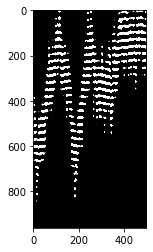

In [19]:
plt.imshow(emc.membership_probability, vmin=0, vmax=0.0001, cmap='gray')
emc.membership_probability.shape

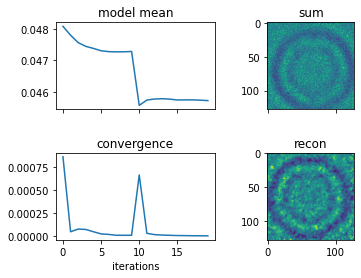

In [20]:
fig = emc2d.viz.show_emc_state(emc)

mse = 15.422


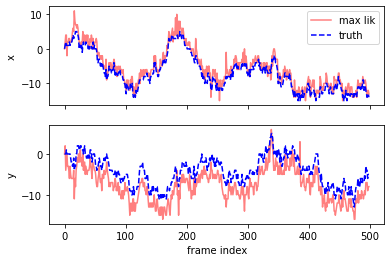

In [21]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [22]:
pmat2 = emc.folded_membership_probability